In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Sets up a matrix of polynomial features for a given input vector X
# For example, if X = [x1, x2, x3, x4] and k = 4, the output will be:   [1, x1, x1^2, x1^3]
#                                                                       [1, x2, x2^2, x2^3]
#                                                                       [1, x3, x3^2, x3^3]
#                                                                       [1, x4, x4^2, x4^3]
# The first column is all ones, which is the bias term  
# The second column is the original input vector
# The third column is the square of the input vector
# The fourth column is the cube of the input vector
def extract_polynomial_features(X, k):
    features = [np.ones_like(X)]
    
    for degree in range(1, k):
        features.append(np.power(X, degree))
    
    # Concatenate all the features into a single array along axis=1 (column-wise concatenation)
    return np.concatenate(features, axis=1)

In [13]:
# Find best w for that X and Y
# hat w = (phi^T * phi)^-1 * phi^T * y
def hat_w(X, y, k):
    phi = extract_polynomial_features(X, k)
    w = np.linalg.solve(phi.T @ phi, phi.T @ y)
    return w

In [14]:
def hat_w_pinv(X, y, k):
    phi = extract_polynomial_features(X, k)
    w = np.linalg.pinv(phi.T @ phi) @ phi.T @ y
    return w

In [15]:
def hat_w_reg(X, Y, k, lambda_reg=1e-5):
    Phi = extract_polynomial_features(X, k)
    i = np.eye(Phi.shape[1])
    w = np.linalg.inv(Phi.T @ Phi + lambda_reg * i) @ Phi.T @ Y
    return w

In [16]:
# Predicts the fitting when provided with new X values (test) 
def predict_polynomial(X, w, k):
    phi = extract_polynomial_features(X, k)
    return phi @ w

In [17]:
def g_sigma(x, sigma=0.07):
    sin_squared = np.sin(2 * np.pi * x)**2
    epsilon = np.random.normal(0, sigma, size=x.shape) # Size gets the number of epsilons based off the number of x values
    
    return sin_squared + epsilon

In [18]:
# Generate training data points
# reshape(-1, 1) reshapes the array into a column vector
x_train = np.random.uniform(0, 1, 30).reshape(-1, 1)
y_train = g_sigma(x_train, sigma=0.07)

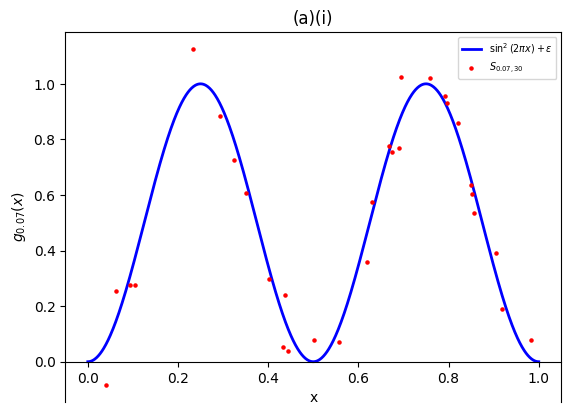

In [19]:
# (a)(i)
# Prepare plotting sin^2(2*pi*x)
x_fine = np.linspace(0, 1, 1000).reshape(-1, 1)
y_fine = (np.sin(2 * np.pi * x_fine)**2).reshape(-1, 1)

# Plot function
plt.plot(x_fine, y_fine, label=r'$\sin^2(2\pi x) + \epsilon$', color='blue', lw=2)
plt.scatter(x_train, y_train, color='red', label=r'$S_{0.07,30}$', zorder=5, s=5)

plt.xlabel('x')
plt.ylabel('$g_{0.07}(x)$')
plt.title('(a)(i)')
plt.legend(fontsize='x-small')
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
plt.show()

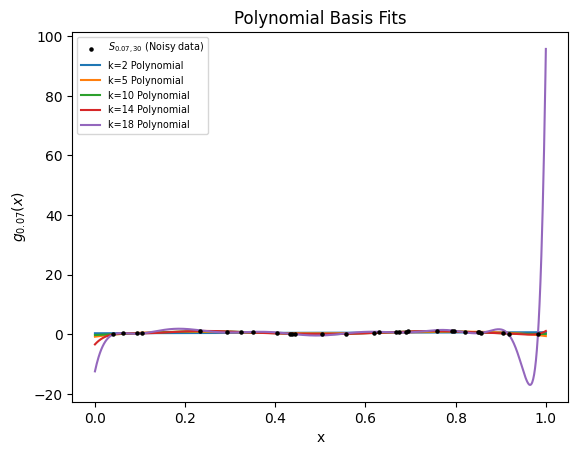

In [20]:
# (a)(ii)
# Plot the noisy data points
plt.scatter(x_train, y_train, color='black', label=r'$S_{0.07,30}$ (Noisy data)', zorder=5, s=5)

for k in [2, 5, 10, 14, 18]:
    w = hat_w(x_train, y_train, k)
    # Predict the values using the fitted polynomial model creates a function to plot
    y_fitted = predict_polynomial(x_fine, w, k)
    # Plot the fitted curve
    plt.plot(x_fine, y_fitted, label=f'k={k} Polynomial')

# Add labels and title
plt.xlabel('x')
plt.ylabel('$g_{0.07}(x)$')
plt.title('Polynomial Basis Fits')
plt.legend(fontsize = 'x-small' )
plt.show()

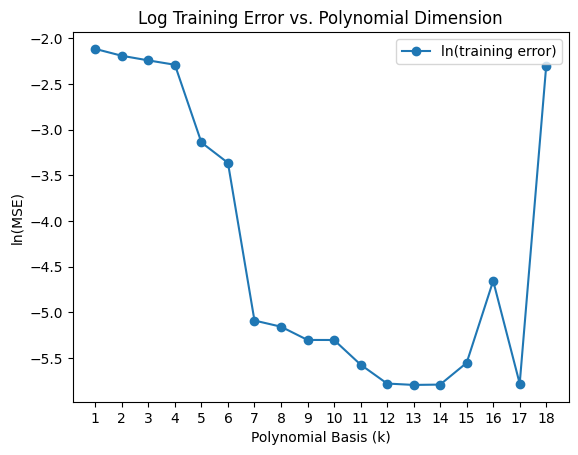

In [21]:
# (b)
training_errors = []

for k in range(1,19):
    w = hat_w(x_train, y_train, k)
    
    # Creates a function based of the polynomial degree, k, and 
    y_fitted = predict_polynomial(x_train, w, k)
    
    mse = np.mean((y_train - y_fitted)**2)
    training_errors.append(mse)
    
ln_training_errors = np.log(training_errors)

plt.plot(range(1, 19), ln_training_errors, marker='o', label="ln(training error)")

plt.xlabel('Polynomial Basis (k)')
plt.ylabel('ln(MSE)')
plt.title('Log Training Error vs. Polynomial Dimension')
plt.xticks(range(1, 19))
plt.legend()
plt.show()

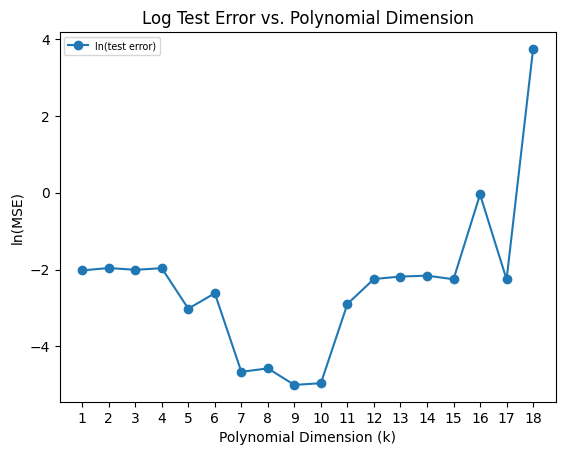

In [22]:
# (c)
# Generate test set T with 1000 samples
x_test = np.random.uniform(0, 1, 1000).reshape(-1, 1)
y_test = g_sigma(x_test, sigma=0.07)

test_errors = []

for k in range(1, 19):
    w_train = hat_w(x_train, y_train, k)
    
    phi_test = extract_polynomial_features(x_test, k)
    
    y_test_pred = phi_test @ w_train
    
    mse_test = np.mean((y_test - y_test_pred)**2)
    test_errors.append(mse_test)

ln_test_errors = np.log(test_errors)

plt.plot(range(1, 19), ln_test_errors, marker='o', label="ln(test error)")
plt.xlabel('Polynomial Dimension (k)')
plt.ylabel('ln(MSE)')
plt.title('Log Test Error vs. Polynomial Dimension')
plt.xticks(range(1, 19))
plt.legend(fontsize='x-small')
plt.show()

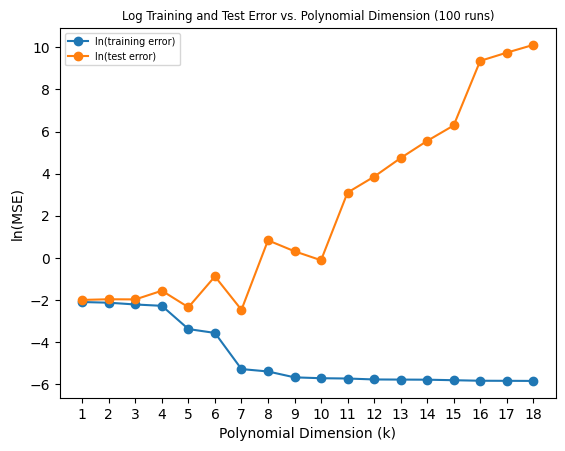

In [23]:
# (d)

num_runs = 100
training_errors = np.zeros(18)
test_errors = np.zeros(18)

X_test = np.random.uniform(0, 1, 1000).reshape(-1, 1)
Y_test = g_sigma(X_test, sigma=0.07)

for run in range(num_runs):

    X_train = np.random.uniform(0, 1, 30).reshape(-1, 1)
    Y_train = g_sigma(X_train, sigma=0.07)

    for k in range(1, 19):
        
        # Pseudoinverse
        W_train = hat_w_pinv(X_train, Y_train, k)

        # Regularized
        # W_train = hat_w_reg(X_train, Y_train, k, lambda_reg=1e-5)

        Y_train_pred = predict_polynomial(X_train, W_train, k)
        Y_test_pred = predict_polynomial(X_test, W_train, k)

        training_errors[k-1] += np.mean((Y_train - Y_train_pred)**2)
        test_errors[k-1] += np.mean((Y_test - Y_test_pred)**2)

training_errors /= num_runs
test_errors /= num_runs

ln_training_errors = np.log(training_errors)
ln_test_errors = np.log(test_errors)

plt.plot(range(1, 19), ln_training_errors, marker='o', label="ln(training error)")
plt.plot(range(1, 19), ln_test_errors, marker='o', label="ln(test error)")
plt.xlabel('Polynomial Dimension (k)')
plt.ylabel('ln(MSE)')
plt.title(f'Log Training and Test Error vs. Polynomial Dimension ({num_runs} runs)', fontsize='small')
plt.xticks(range(1, 19))
plt.legend(fontsize='x-small')
plt.show()
